<a href="https://colab.research.google.com/github/Jungleislander/AI-pneumonia-classifier/blob/main/notebooks/deployed_model_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-tpu -f https://storage.googleapis.com/libtpu-tf-releases/index.html --force


Looking in links: https://storage.googleapis.com/libtpu-tf-releases/index.html
  Using cached tensorflow_tpu-2.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached absl_py-2.3.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached protobuf-5.29.5-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached six-1.1

In [2]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

/usr/local/lib/python3.11/dist-packages/jax/__init__.py:31: UserWarning: cloud_tpu_init failed: AttributeError("module 'libtpu' has no attribute 'get_library_path'")
 This a JAX bug; please report an issue at https://github.com/jax-ml/jax/issues
  _warn(f"cloud_tpu_init failed: {exc!r}\n This a JAX bug; please report "


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: 
Number of replicas: 8


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]
EPOCHS = 25
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
GCS_PATH = "/content/drive/MyDrive/pneumonia-data"

In [5]:
filenames = tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(GCS_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1101
Pneumonia images count in training set: 3107


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

for f in train_list_ds.take(5):
    print(f.numpy())

b'/content/drive/MyDrive/pneumonia-data/chest_xray/train/PNEUMONIA/person1198_bacteria_3148.jpeg'
b'/content/drive/MyDrive/pneumonia-data/chest_xray/train/PNEUMONIA/person1368_virus_2354.jpeg'
b'/content/drive/MyDrive/pneumonia-data/chest_xray/train/PNEUMONIA/person1728_bacteria_4556.jpeg'
b'/content/drive/MyDrive/pneumonia-data/chest_xray/train/PNEUMONIA/person60_bacteria_285.jpeg'
b'/content/drive/MyDrive/pneumonia-data/chest_xray/train/PNEUMONIA/person502_bacteria_2119.jpeg'


In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4208
Validating images count: 1052


In [9]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(GCS_PATH + "/chest_xray/train/*"))])
CLASS_NAMES

array(['NORMAL', 'PNEUMONIA'], dtype='<U9')

In [10]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return 1 if parts[-2] == "PNEUMONIA" else 0

In [11]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [12]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [14]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


In [15]:
test_list_ds = tf.data.Dataset.list_files(str(GCS_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

TEST_IMAGE_COUNT

np.int64(624)

In [16]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [17]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

In [18]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

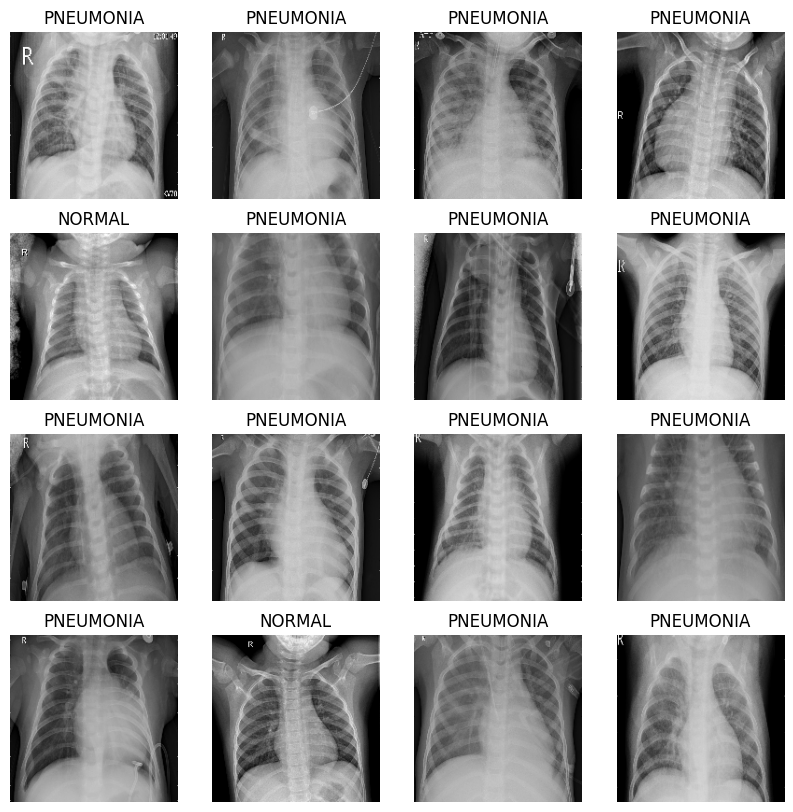

In [19]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [20]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )

    return block

In [21]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

In [22]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [23]:
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([1.03743877])

In [24]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.91
Weight for class 1: 0.68


In [25]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [26]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 66s 833ms/step - accuracy: 0.6739 - loss: 0.7084 - precision: 0.8748 - recall: 0.6503 - val_accuracy: 0.7373 - val_loss: 0.6068 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.8974 - loss: 0.3012 - precision: 0.9667 - recall: 0.8890 - val_accuracy: 0.7402 - val_loss: 0.5743 - val_precision: 0.7402 - val_recall: 1.0000
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.9014 - loss: 0.2627 - precision: 0.9460 - recall: 0.9144 - val_accuracy: 0.7373 - val_loss: 0.6182 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 182ms/step - accuracy: 0.9258 - loss: 0.2253 - precision: 0.9617 - recall: 0.9333 - val_accuracy: 0.7373 - val_loss: 0.6636 - val_precision: 0.7373 - val_recall: 1.0000
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.9307 - loss: 0.1789 - precision: 0.9836 - recall: 0.9186 - val_accuracy: 0.7344 - val_loss: 0

In [32]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.keras",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [33]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [34]:
history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 381ms/step - accuracy: 0.9450 - loss: 0.0873 - precision: 0.9909 - recall: 0.9368 - val_accuracy: 0.6426 - val_loss: 1.2845 - val_precision: 1.0000 - val_recall: 0.5159 - learning_rate: 0.0100
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.9445 - loss: 0.1427 - precision: 0.9819 - recall: 0.9400 - val_accuracy: 0.8408 - val_loss: 0.8551 - val_precision: 0.9820 - val_recall: 0.7981 - learning_rate: 0.0089
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.9219 - loss: 0.2009 - precision: 0.9865 - recall: 0.9134 - val_accuracy: 0.8193 - val_loss: 0.8011 - val_precision: 1.0000 - val_recall: 0.7540 - learning_rate: 0.0079
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.9337 - loss: 0.1968 - precision: 0.9608 - recall: 0.9468 - val_accuracy: 0.8975 - val_loss: 0.3553 - val_precision: 1.0000 - val_recall: 0.8613 - learning_rate: 0.0071
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accu

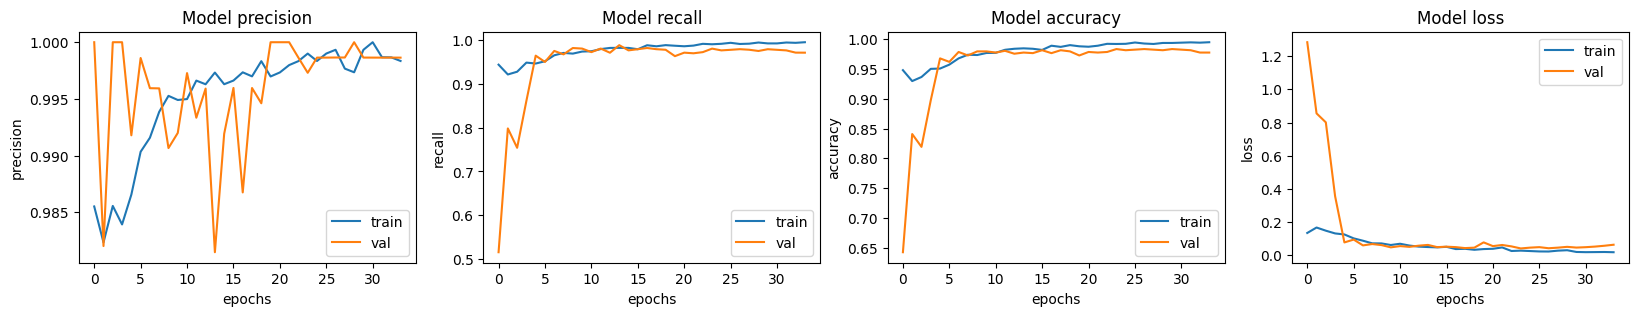

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [36]:
loss, acc, prec, rec = model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7133 - loss: 1.2956 - precision: 0.6773 - recall: 1.0000
